In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from reader import Reader
import matplotlib.patches as patches

In [32]:
reader = Reader("./data/real_052425/")

def analyze(r):
    df_sent = pd.DataFrame(r.sent_chunks)
    df_acked = pd.DataFrame(r.acked_chunks)
    df_buf  = pd.DataFrame(r.buffer_level)


    for df, dtypes in [
        (df_sent, {"timestamp": int, "size": int, "video_ts": int}),
        (df_acked, {"timestamp": int, "video_ts": int}),
        (df_buf,  {"timestamp": int, "buffer": float, "cum_rebuf": float})]:
        for col, typ in dtypes.items():
            df[col] = df[col].astype(typ)

    for df in (df_sent, df_acked, df_buf):
        df["session_id"] = df["session_id"].astype(str)

    print(df_sent.head())
    print(df_acked.head())
    print(df_buf.head())
    #print(df_buf)

    group_df = df_sent.merge(df_buf, on=["expt_id","session_id","timestamp"], how="left")
    print(group_df.head())
    #group_df = group_df.merge(df_acked, on=["expt_id","session_id","timestamp"], how="left")
    #print(group_df)
    return df_sent, df_acked, df_buf, group_df

df_sent, df_acked, df_buf, group_df = analyze(reader)

             timestamp                                    session_id index  \
0  1748002167625000000  z4e5qmKUImHc/kbUas+xa/pQjPRFhZhthEIBz92VDsg=     6   
1  1748002167665000000  z4e5qmKUImHc/kbUas+xa/pQjPRFhZhthEIBz92VDsg=     6   
2  1748002167704000000  z4e5qmKUImHc/kbUas+xa/pQjPRFhZhthEIBz92VDsg=     6   
3  1748002167740000000  z4e5qmKUImHc/kbUas+xa/pQjPRFhZhthEIBz92VDsg=     6   
4  1748002167790000000  z4e5qmKUImHc/kbUas+xa/pQjPRFhZhthEIBz92VDsg=     6   

  expt_id channel      video_ts       format    size ssim_index cwnd  \
0    2216     abc  127948700880  1280x720-20  402111   0.984716  784   
1    2216     abc  127948881060  1280x720-20  382769   0.984888  662   
2    2216     abc  127949061240  1280x720-20  393072    0.98451  662   
3    2216     abc  127949241420  1280x720-20  635186   0.985032  684   
4    2216     abc  127949421600  1280x720-20  507943    0.98557  732   

  in_flight min_rtt    rtt delivery_rate  
0         0   16161  17534      12870822  
1         0 

In [3]:
print(len(df_sent))
print(len(df_acked))
print(len(df_buf))
print(len(group_df))
print(group_df.columns)
print(df_buf.columns)

3936400
3930217
28176903
3936400
Index(['timestamp', 'session_id', 'index_x', 'expt_id', 'channel_x',
       'video_ts', 'format', 'size', 'ssim_index', 'cwnd', 'in_flight',
       'min_rtt', 'rtt', 'delivery_rate', 'index_y', 'channel_y', 'event',
       'buffer', 'cum_rebuf'],
      dtype='object')
Index(['timestamp', 'session_id', 'index', 'expt_id', 'channel', 'event',
       'buffer', 'cum_rebuf'],
      dtype='object')


In [75]:

group_keys = ["expt_id", "session_id"]
group_df["ssim_index"] = group_df["ssim_index"].astype(np.float64)
group_df["delivery_rate"] = group_df["delivery_rate"].astype(np.float64)
group_df["rtt"] = group_df["rtt"].astype(np.float64)
group_df["qual_throughput"] = pd.qcut(group_df["rtt"].astype(np.float64), 3, labels=["low","medium","high"])
group_df["qual_rtt"] = pd.qcut(group_df["rtt"].astype(np.float64), 3, labels=["low","medium","high"])
grouped_group = group_df.groupby(group_keys)

#total_rebuf = grouped_group[["cum_rebuf", "ssim_index"]]
#print(len(total_rebuf))
#print(total_rebuf)

In [24]:
print(grouped_group["channel_x"].max())

expt_id  session_id                                  
2216     +0ygIyRSTvbIUhVLiJ2msIf3YVGpHSRSVrDZjYUyK00=    nbc
         +EFJzVjyY2ShLXRWmFQifRueaqkezVYQkucB6mvIu/I=    abc
         +If9b2t4NT7j07G3395QIjb088TNiQb+INHQygsTkUI=    pbs
         +IgK0hMWdtQCpXiqWoUtS6mtD2Zecyc3JR0JXOYl4+w=    fox
         +LI7RC4M0e0e5JhueFztwLmp8/dz2T93BX7j9LrVKrE=    nbc
                                                        ... 
2223     xrEqM6Igfe8vKycZMXJsetqnDFhCwX/o/+OriBRPEok=    cbs
         xw1HP4P/11kGQpqBmjnqnQixVUnl76g5zxINpjgTAFc=    pbs
         z3QsS4RLaI2USKOiFCDxE1qRGWMpja67rkE/1Wt23tY=    cbs
         zEZA7q7zs0sP1yP0emxNvihBvFRjL2Pp/BqiEv4orDM=    pbs
         zWH0936q0zBWPVDRqSSTX/mw+XPZd99FGqPH7srwiD0=    pbs
Name: channel_x, Length: 2388, dtype: object


In [80]:
time_s = (grouped_group["timestamp"].max() - grouped_group["timestamp"].min()).apply(lambda x: float(x) / 1000000000.0)
#print(time_ns)
norm_rebuf = grouped_group["cum_rebuf"].max() / time_s
norm_rebuf = norm_rebuf.dropna()
ssim = grouped_group["ssim_index"].mean()
print(norm_rebuf)
print(ssim)
graph_df = pd.DataFrame({"rebuf": norm_rebuf,
                         "channel": grouped_group["channel_x"].max(),
                         "avg_buffer": grouped_group["buffer"].mean(),
                         "std_throughput": grouped_group["delivery_rate"].std(),
                         "std_latency": grouped_group["rtt"].std(),
                         "qual_throughput": grouped_group["qual_throughput"].min(),
                         "qual_latency": grouped_group["qual_rtt"].min()
                        }).merge(ssim, how="inner", on=["expt_id", "session_id"])
#total_rebuf.max()

expt_id  session_id                                  
2216     +0ygIyRSTvbIUhVLiJ2msIf3YVGpHSRSVrDZjYUyK00=    0.491447
         +EFJzVjyY2ShLXRWmFQifRueaqkezVYQkucB6mvIu/I=    0.000136
         +If9b2t4NT7j07G3395QIjb088TNiQb+INHQygsTkUI=    0.002514
         +MIQY/1L7Jd3Ut11gsW3GrcXfKPI8zyS4XZmdSwfMaI=    0.000009
         +hVRzq4u2lcru2IN8qs+kG4WXBtrFk1d4wUcLFaOFyo=    0.000402
                                                           ...   
2223     xg3PZ+mLdSwe5R4eDMNS+atzcYFUSMjxj5x/GFz/HKQ=    0.021823
         xrEqM6Igfe8vKycZMXJsetqnDFhCwX/o/+OriBRPEok=    0.000087
         xw1HP4P/11kGQpqBmjnqnQixVUnl76g5zxINpjgTAFc=    0.000000
         zEZA7q7zs0sP1yP0emxNvihBvFRjL2Pp/BqiEv4orDM=    0.001549
         zWH0936q0zBWPVDRqSSTX/mw+XPZd99FGqPH7srwiD0=    0.000064
Length: 1921, dtype: float64
expt_id  session_id                                  
2216     +0ygIyRSTvbIUhVLiJ2msIf3YVGpHSRSVrDZjYUyK00=    0.962098
         +EFJzVjyY2ShLXRWmFQifRueaqkezVYQkucB6mvIu/I=    0.982649
     

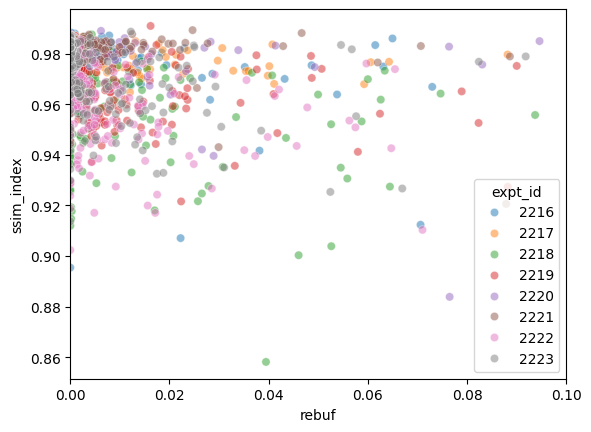

In [7]:
ax = sns.scatterplot(graph_df, x="rebuf",y="ssim_index", hue="expt_id", alpha=0.5)
ax.set_xlim([0.0,0.1])
plt.show()

In [8]:
import json

name_lookup = {}
expt_lookup_f = "./data/real_052425/logs/expt_settings"
with open(expt_lookup_f, "r") as f:
    for line in f:
        words = line.split(" ")
        exp_id = int(words[0])
        json_s = " ".join(words[1:])
        j_obj = json.loads(json_s)
        try:
            if j_obj["abr"] == "puffer_ttp":
                name_lookup[exp_id] = j_obj["abr_name"]
            else:
                name_lookup[exp_id] = j_obj["abr"]
        except KeyError as e:
            continue

#print(name_lookup)

In [81]:
graph_df = graph_df.reset_index()
graph_df["expt_id"] = graph_df["expt_id"].apply(lambda x: name_lookup[int(x)])

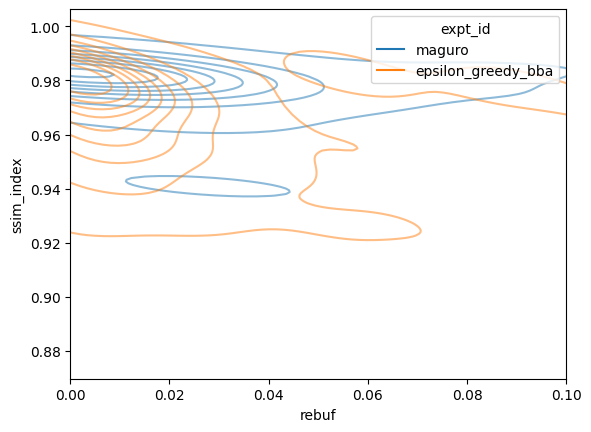

In [10]:
fig, ax = plt.subplots()
ax.set_xlim([0.0,0.1])
filt_graph = graph_df[(graph_df["expt_id"] == "epsilon_greedy_bba") | (graph_df["expt_id"] == "maguro")]
sns.kdeplot(filt_graph, x="rebuf",y="ssim_index", hue="expt_id", alpha=0.5, ax=ax)
plt.show()

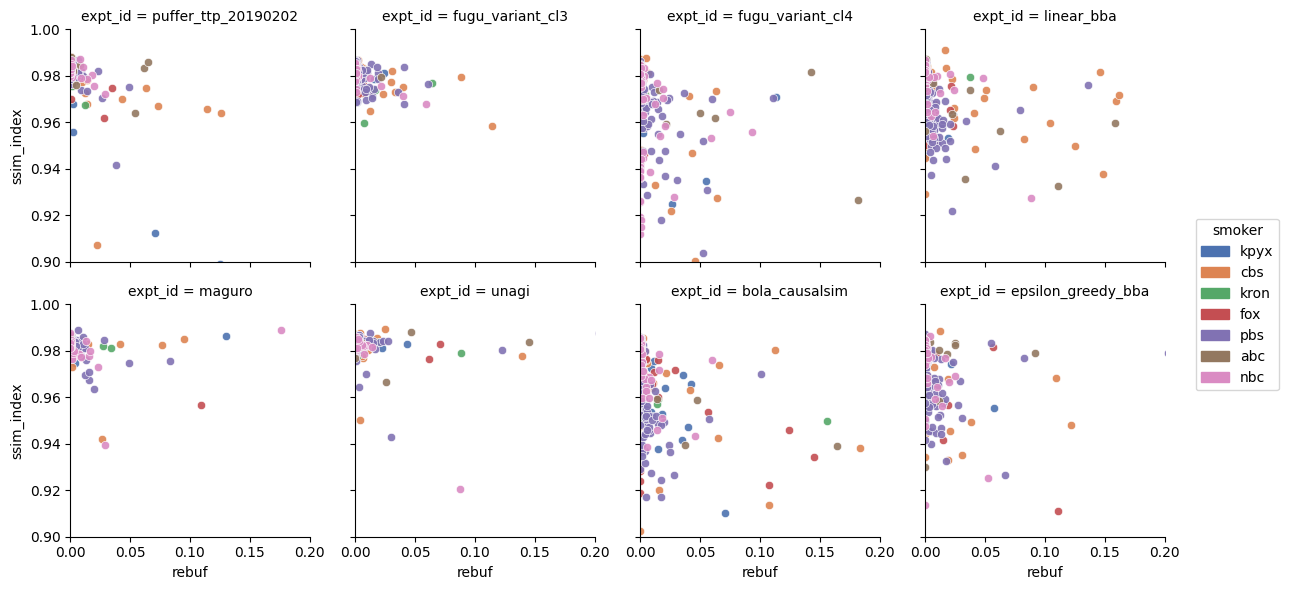

In [46]:
import matplotlib.patches as patches
hue_order = graph_df["channel"].unique()[::-1]

grid = sns.FacetGrid(graph_df, col="expt_id", hue="channel", hue_order=hue_order, palette="deep", col_wrap=4, xlim=(0,0.2), ylim=(0.9,1.0))
#grid.add_legend()
grid.map(sns.scatterplot,"rebuf","ssim_index",alpha=0.9)


# seaborn legend is broken and doesn't add colors
labels = hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col, label=lab) for col, lab in zip (colors, labels)]
plt.legend(handles=handles, title='smoker', loc='center left', bbox_to_anchor=(1.1, 1))
plt.show()

In [55]:
print(df_sent["channel"].describe())
print(df_sent["delivery_rate"].astype(np.float64).describe())
print(df_sent["rtt"].astype(np.float64).describe())

count     3936400
unique          7
top           abc
freq       930567
Name: channel, dtype: object
count    3.936400e+06
mean     8.488933e+06
std      1.540344e+07
min      1.460000e+02
25%      2.239357e+06
50%      6.339573e+06
75%      1.155633e+07
max      8.350703e+08
Name: delivery_rate, dtype: float64
count    3.936400e+06
mean     8.108006e+04
std      1.063726e+05
min      1.055000e+03
25%      3.765300e+04
50%      6.463700e+04
75%      8.975400e+04
max      2.184674e+07
Name: rtt, dtype: float64


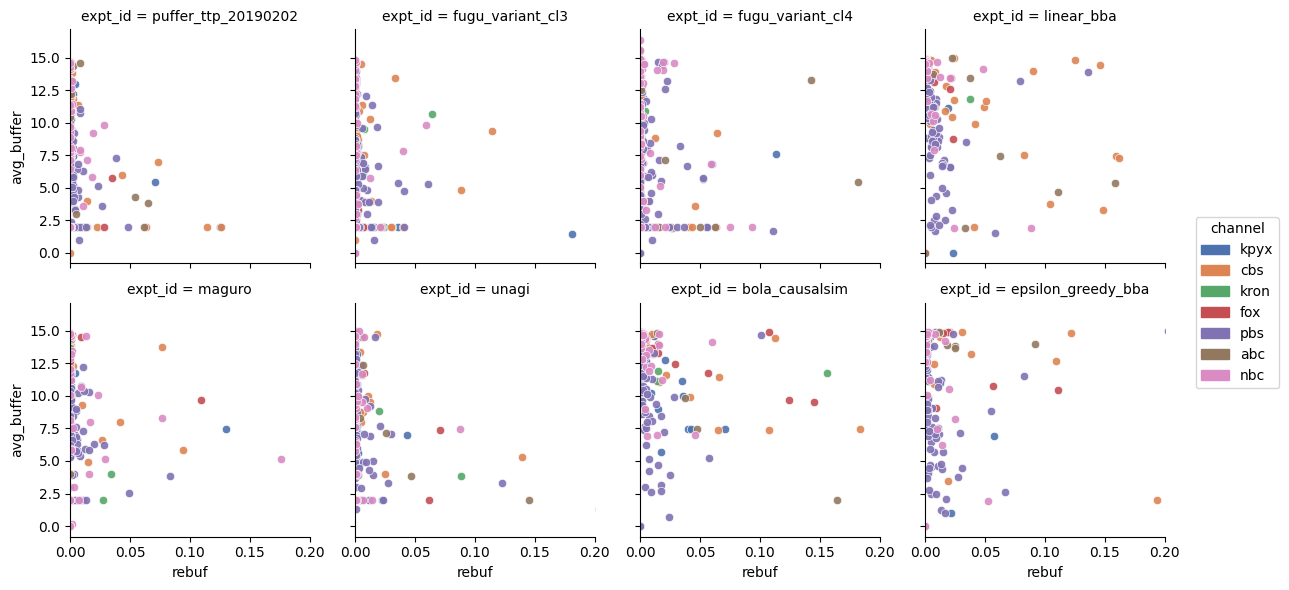

In [56]:

hue_order = graph_df["channel"].unique()[::-1]

grid = sns.FacetGrid(graph_df, col="expt_id", hue="channel", hue_order=hue_order, palette="deep", col_wrap=4,xlim=(0,0.2))
#grid.add_legend()
grid.map(sns.scatterplot,"rebuf","avg_buffer",alpha=0.9)


# seaborn legend is broken and doesn't add colors
labels = hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col, label=lab) for col, lab in zip (colors, labels)]
plt.legend(handles=handles, title='channel', loc='center left', bbox_to_anchor=(1.1, 1))
plt.show()

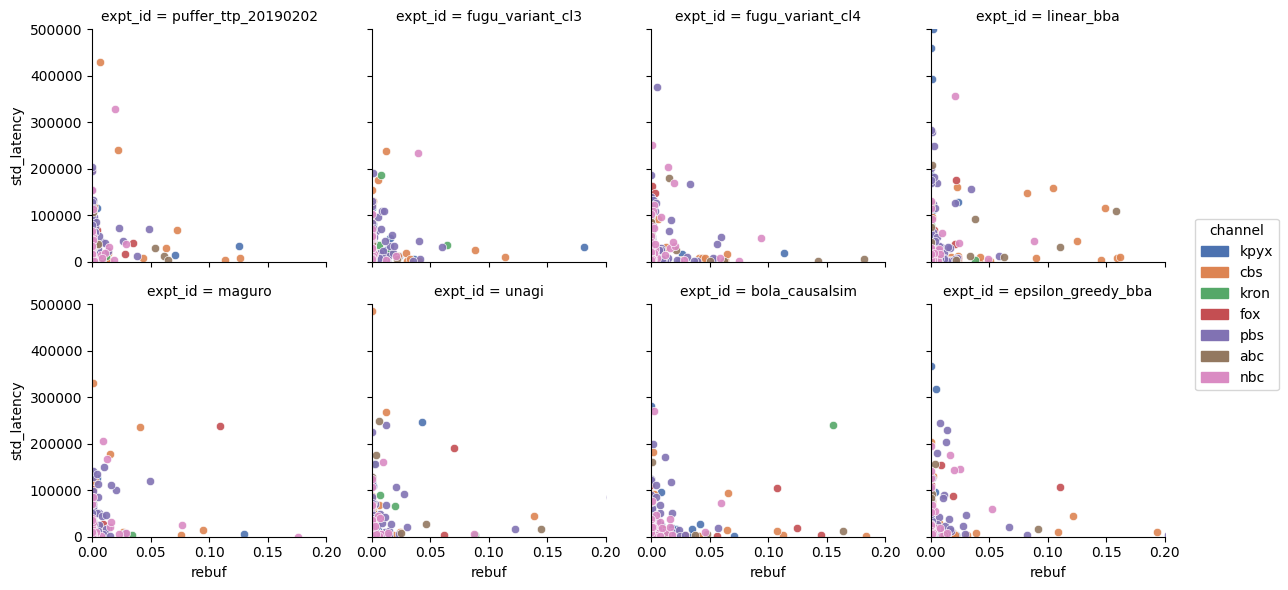

In [69]:
hue_order = graph_df["channel"].unique()[::-1]

grid = sns.FacetGrid(graph_df, col="expt_id", hue="channel", hue_order=hue_order, palette="deep", col_wrap=4,xlim=(0,0.2),ylim=(0,500000))
#grid.add_legend()
grid.map(sns.scatterplot,"rebuf","std_latency",alpha=0.9)


# seaborn legend is broken and doesn't add colors
labels = hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col, label=lab) for col, lab in zip (colors, labels)]
plt.legend(handles=handles, title='channel', loc='center left', bbox_to_anchor=(1.1, 1))
plt.show()

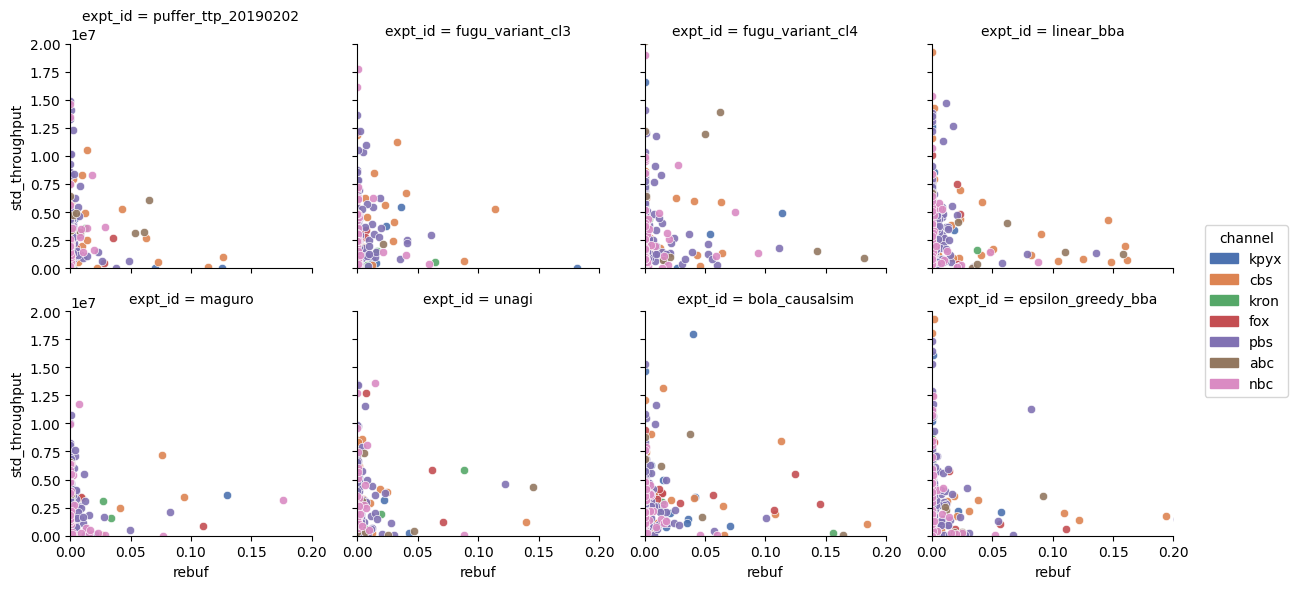

In [74]:
hue_order = graph_df["channel"].unique()[::-1]

grid = sns.FacetGrid(graph_df, col="expt_id", hue="channel", hue_order=hue_order, palette="deep", col_wrap=4,xlim=(0,0.2),ylim=(0,20000000))
#grid.add_legend()
grid.map(sns.scatterplot,"rebuf","std_throughput",alpha=0.9)


# seaborn legend is broken and doesn't add colors
labels = hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col, label=lab) for col, lab in zip (colors, labels)]
plt.legend(handles=handles, title='channel', loc='center left', bbox_to_anchor=(1.1, 1))
plt.show()

/Users/parkercarlson/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


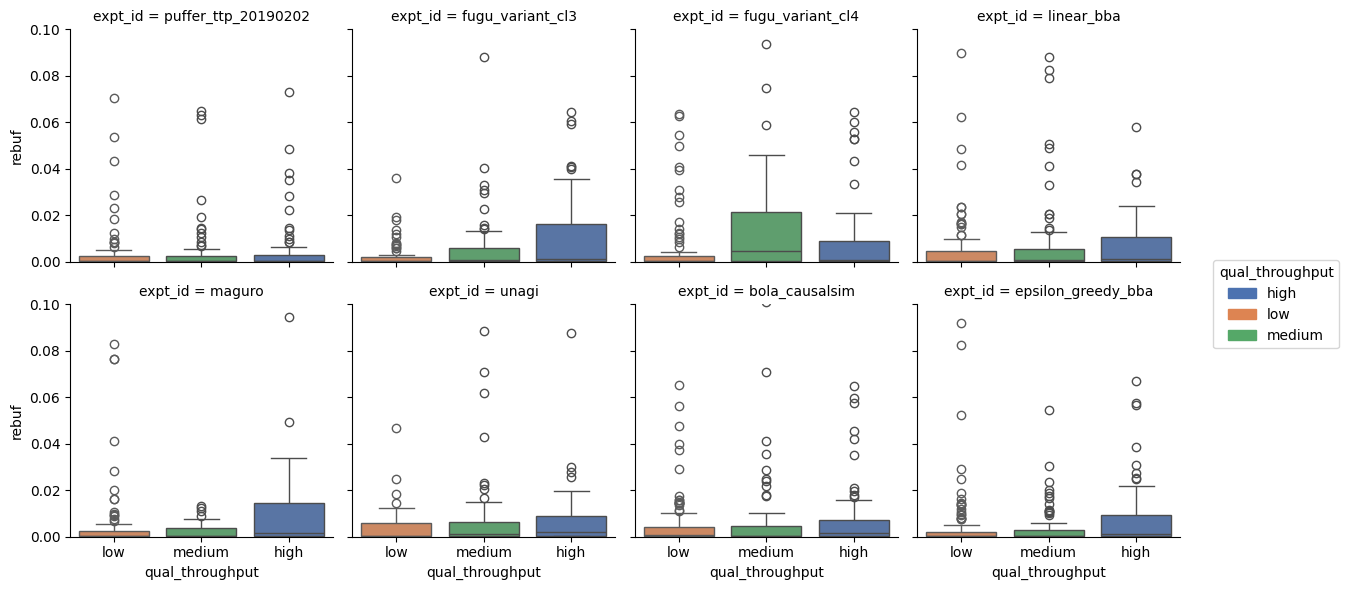

In [90]:
hue_order = graph_df["qual_throughput"].unique()[::-1]

grid = sns.FacetGrid(graph_df, col="expt_id", hue="qual_throughput", hue_order=hue_order, palette="deep", col_wrap=4,ylim=(0,0.1))
#grid.add_legend()
grid.map(sns.boxplot,"qual_throughput","rebuf")


# seaborn legend is broken and doesn't add colors
labels = hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col, label=lab) for col, lab in zip (colors, labels)]
plt.legend(handles=handles, title='qual_throughput', loc='center left', bbox_to_anchor=(1.1, 1))
plt.show()

/Users/parkercarlson/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


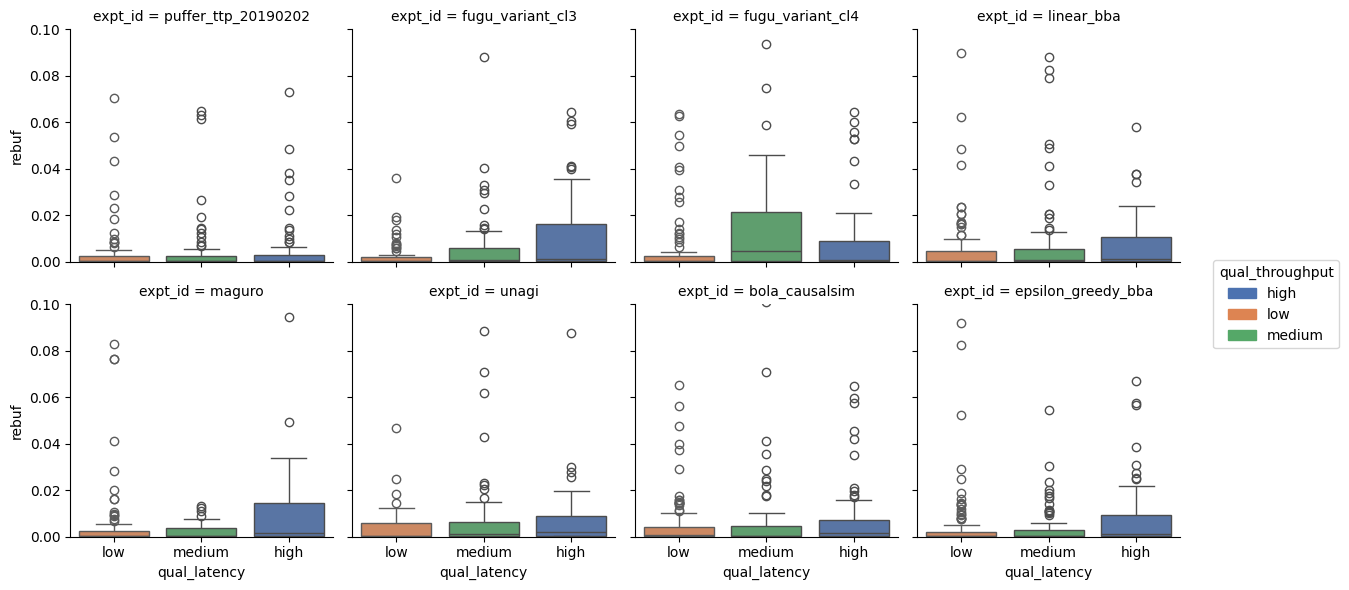

In [89]:
hue_order = graph_df["qual_latency"].unique()[::-1]

grid = sns.FacetGrid(graph_df, col="expt_id", hue="qual_latency", hue_order=hue_order, palette="deep", col_wrap=4,ylim=(0,0.1))
#grid.add_legend()
grid.map(sns.boxplot,"qual_latency","rebuf")


# seaborn legend is broken and doesn't add colors
labels = hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col, label=lab) for col, lab in zip (colors, labels)]
plt.legend(handles=handles, title='qual_throughput', loc='center left', bbox_to_anchor=(1.1, 1))
plt.show()

In [25]:
reader = Reader("./data/fugu_bbr_exp/")

def analyze(r):
    df_sent = pd.DataFrame(r.sent_chunks)
    df_acked = pd.DataFrame(r.acked_chunks)
    df_buf  = pd.DataFrame(r.buffer_level)


    for df, dtypes in [
        (df_sent, {"timestamp": int, "size": int, "video_ts": int}),
        (df_acked, {"timestamp": int, "video_ts": int}),
        (df_buf,  {"timestamp": int, "buffer": float, "cum_rebuf": float})]:
        for col, typ in dtypes.items():
            df[col] = df[col].astype(typ)

    for df in (df_sent, df_acked, df_buf):
        df["session_id"] = df["session_id"].astype(str)

    print(df_sent.head())
    print("==================================")
    #print(df_acked.head())
    print(df_buf.head())
    #print(df_buf)

    # rename ucsb columns to match order from stanford puffer
    df_sent = df_sent.rename(columns={"session_id": "channel",
                                     "channel": "session_id"})
    df_buf = df_buf.rename(columns={"session_id": "channel",
                                     "expt_id": "event",
                                     "channel": "expt_id",
                                     "event": "session_id"})
    
    

    group_df = df_sent.merge(df_buf, on=["expt_id","session_id","index","channel"], how="left")
    print(group_df.head())
    #group_df = df_sent.merge(df_acked, on=["expt_id","session_id","timestamp"], how="left")
    #print(group_df)
    return df_sent, df_acked, df_buf, group_df

df_sent, df_acked, df_buf, group_df = analyze(reader)

       timestamp session_id index expt_id channel    video_ts      format  \
0  1748300102826        nbc     1      13  jaber2  4136990950  4136990951   
1  1748300102906        nbc     1      13  jaber4  1445366029  1445366030   
2  1748300102986        nbc     1      13  jaber8  2411769998  2411769999   
3  1748300103194        nbc     1      13  jaber9    54638869    54638870   
4  1748300103262        nbc     1      13  jaber7  1166858096  1166858097   

      size    ssim_index   cwnd in_flight min_rtt rtt delivery_rate  
0  3063060  1920x1080-22  33823  0.998969      68   0        100277  
1  3063060  1920x1080-22  33823  0.998969      68   0        100208  
2  3063060  1920x1080-22  33823  0.998969      68   0        100236  
3  3063060  1920x1080-22  33823  0.998969      68   0        100153  
4  3063060  1920x1080-22  33823  0.998969      68   0        100260  
       timestamp session_id index expt_id channel   event        buffer  \
0  1748300102668        nbc     1   timer 

In [22]:
print(group_df.head())
print(group_df.describe())

     timestamp_x session_id index expt_id channel_x    video_ts      format  \
0  1748300102826        nbc     1      13    jaber2  4136990950  4136990951   
1  1748300102906        nbc     1      13    jaber4  1445366029  1445366030   
2  1748300102986        nbc     1      13    jaber8  2411769998  2411769999   
3  1748300103194        nbc     1      13    jaber9    54638869    54638870   
4  1748300103262        nbc     1      13    jaber7  1166858096  1166858097   

      size    ssim_index   cwnd in_flight min_rtt rtt delivery_rate  \
0  3063060  1920x1080-22  33823  0.998969      68   0        100277   
1  3063060  1920x1080-22  33823  0.998969      68   0        100208   
2  3063060  1920x1080-22  33823  0.998969      68   0        100236   
3  3063060  1920x1080-22  33823  0.998969      68   0        100153   
4  3063060  1920x1080-22  33823  0.998969      68   0        100260   

   timestamp_y channel_y event  buffer  cum_rebuf  
0          NaN       NaN   NaN     NaN        

In [28]:
group_keys = ["expt_id", "session_id"]
#group_df["ssim_index"] = group_df["ssim_index"].astype(np.float64)
group_df["delivery_rate"] = group_df["delivery_rate"].astype(np.float64)
group_df["rtt"] = group_df["rtt"].astype(np.float64)
group_df["qual_throughput"] = pd.qcut(group_df["delivery_rate"].astype(np.float64), 3, labels=["low","medium","high"])
#group_df["qual_rtt"] = pd.qcut(group_df["rtt"].astype(np.float64), 2, labels=["low","high"])
grouped_group = group_df.groupby(group_keys)


time_s = (grouped_group["timestamp_x"].max() - grouped_group["timestamp_x"].min()).apply(lambda x: float(x) / 1000000000.0)
norm_rebuf = grouped_group["cum_rebuf"].max() / time_s
norm_rebuf = norm_rebuf.dropna()
#ssim = grouped_group["ssim_index"].mean()
graph_df = pd.DataFrame({"rebuf": norm_rebuf,
                         "channel": grouped_group["channel"].max(),
                         "avg_buffer": grouped_group["buffer"].mean(),
                         "std_throughput": grouped_group["delivery_rate"].std(),
                         "std_latency": grouped_group["rtt"].std(),
                         "qual_throughput": grouped_group["qual_throughput"].min(),
                         #"qual_latency": grouped_group["qual_rtt"].min()
                        })#.merge(ssim, how="inner", on=["expt_id", "session_id"])

/Users/parkercarlson/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


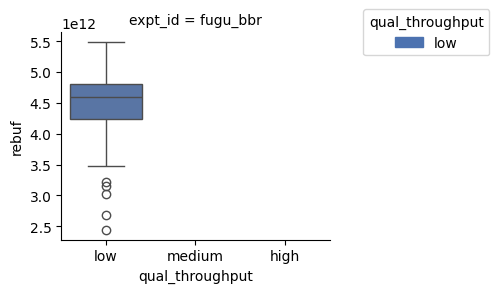

In [34]:
hue_order = graph_df["qual_throughput"].unique()[::-1]
graph_df["expt_id"] = "fugu_bbr"

grid = sns.FacetGrid(graph_df, col="expt_id", hue="qual_throughput", hue_order=hue_order, palette="deep", col_wrap=4)
#grid.add_legend()
grid.map(sns.boxplot,"qual_throughput","rebuf")


# seaborn legend is broken and doesn't add colors
labels = hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col, label=lab) for col, lab in zip (colors, labels)]
plt.legend(handles=handles, title='qual_throughput', loc='center left', bbox_to_anchor=(1.1, 1))
plt.show()

In [35]:
reader = Reader("./data/linear_bba_exp/")

def analyze(r):
    df_sent = pd.DataFrame(r.sent_chunks)
    df_acked = pd.DataFrame(r.acked_chunks)
    df_buf  = pd.DataFrame(r.buffer_level)


    for df, dtypes in [
        (df_sent, {"timestamp": int, "size": int, "video_ts": int}),
        (df_acked, {"timestamp": int, "video_ts": int}),
        (df_buf,  {"timestamp": int, "buffer": float, "cum_rebuf": float})]:
        for col, typ in dtypes.items():
            df[col] = df[col].astype(typ)

    for df in (df_sent, df_acked, df_buf):
        df["session_id"] = df["session_id"].astype(str)

    print(df_sent.head())
    print("==================================")
    #print(df_acked.head())
    print(df_buf.head())
    #print(df_buf)

    # rename ucsb columns to match order from stanford puffer
    df_sent = df_sent.rename(columns={"session_id": "channel",
                                     "channel": "session_id"})
    df_buf = df_buf.rename(columns={"session_id": "channel",
                                     "expt_id": "event",
                                     "channel": "expt_id",
                                     "event": "session_id"})
    
    

    group_df = df_sent.merge(df_buf, on=["expt_id","session_id","index","channel"], how="left")
    print(group_df.head())
    #group_df = df_sent.merge(df_acked, on=["expt_id","session_id","timestamp"], how="left")
    #print(group_df)
    return df_sent, df_acked, df_buf, group_df

_,_,_, linear_group_df = analyze(reader)

       timestamp session_id index expt_id channel    video_ts      format  \
0  1748551836727        cbs     1      14  jaber2  4283091810  4283091810   
1  1748551836768        cbs     1      14  jaber1  2714701316  2714701316   
2  1748551836815        cbs     1      14  jaber9  1109641269  1109641269   
3  1748551836857        cbs     1      14  jaber4  1564167665  1564167665   
4  1748551836923        cbs     1      14  jaber8  4177414311  4177414311   

   size  ssim_index   cwnd in_flight min_rtt rtt delivery_rate  
0     0  426x240-26  30382  0.896249      11   0        100237  
1     0  426x240-26  30382  0.896249      11   0        100193  
2     0  426x240-26  30382  0.896249      11   0        100280  
3     0  426x240-26  30382  0.896249      11   0        100212  
4     0  426x240-26  30382  0.896249      11   0        100231  
       timestamp session_id index expt_id channel   event        buffer  \
0  1748551836726        cbs     1    init      14  jaber2  4.283092e+09 

In [39]:
group_keys = ["expt_id", "session_id"]
#group_df["ssim_index"] = group_df["ssim_index"].astype(np.float64)
group_df["delivery_rate"] = group_df["delivery_rate"].astype(np.float64)
group_df["rtt"] = group_df["rtt"].astype(np.float64)
group_df["qual_throughput"] = pd.qcut(group_df["delivery_rate"].astype(np.float64), 3, labels=["low","medium","high"])
#group_df["qual_rtt"] = pd.qcut(group_df["rtt"].astype(np.float64), 2, labels=["low","high"])
grouped_group = group_df.groupby(group_keys)


time_s = (grouped_group["timestamp_x"].max() - grouped_group["timestamp_x"].min()).apply(lambda x: float(x) / 1000000000.0)
norm_rebuf = grouped_group["cum_rebuf"].max() / time_s
norm_rebuf = norm_rebuf.dropna()
#ssim = grouped_group["ssim_index"].mean()
linear_graph_df = pd.DataFrame({"rebuf": norm_rebuf,
                         "channel": grouped_group["channel"].max(),
                         "avg_buffer": grouped_group["buffer"].mean(),
                         "std_throughput": grouped_group["delivery_rate"].std(),
                         "std_latency": grouped_group["rtt"].std(),
                         "qual_throughput": grouped_group["qual_throughput"].min(),
                         #"qual_latency": grouped_group["qual_rtt"].min()
                        })#.merge(ssim, how="inner", on=["expt_id", "session_id"])

/Users/parkercarlson/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


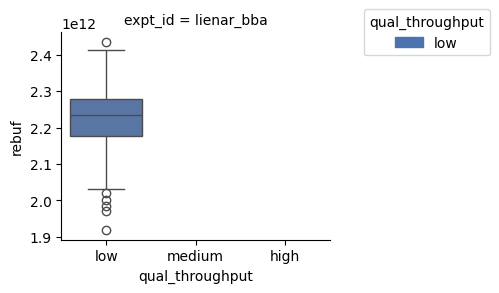

In [40]:


hue_order = linear_graph_df["qual_throughput"].unique()[::-1]
linear_graph_df["expt_id"] = "lienar_bba"

grid = sns.FacetGrid(linear_graph_df, col="expt_id", hue="qual_throughput", hue_order=hue_order, palette="deep", col_wrap=4)
#grid.add_legend()
grid.map(sns.boxplot,"qual_throughput","rebuf")


# seaborn legend is broken and doesn't add colors
labels = hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col, label=lab) for col, lab in zip (colors, labels)]
plt.legend(handles=handles, title='qual_throughput', loc='center left', bbox_to_anchor=(1.1, 1))
plt.show()